In [1]:
import torch 
from GMVAE_beta import GMVAE
import dataloader as dl 
# dev=torch.device("cuda")

In [2]:
gmvae = GMVAE()

In [3]:
gmvae.load_state_dict(torch.load("./models/gmvae.pth"))
gmvae.eval()

GMVAE(
  (encConvStack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fcStack): Sequential(
    (0): Linear(in_features=4096, out_features=500, bias=False)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mu_x): Linear(in_features=500, out_features=200, bias=True)
  (logvar_x): Linear(in_features=500, out_features=200, bias=True)
  (mu_w): Linear(in_features=500, out_features=150, bias=True)
  (logvar_w): Linear(in_

In [4]:
_ , test_loader = dl.mnistloader(batchSize=64)

In [5]:
Z = []
targ = []
for batch_idx, (data, target) in enumerate(test_loader):
	data = data
	
	target = target

	qz, mu_x, logvar_x, mu_w, logvar_w = gmvae.encode(data)

	Z.append(mu_x)
	targ.append(target)

z = torch.stack([item for item in Z[:-1]])
cat = torch.stack([item for item in targ[:-1]])

cat = cat.flatten()
zz = z.reshape(156*64,200)

latent = zz.detach().numpy()
cat = cat.numpy()

In [6]:
from sklearn.manifold import TSNE
import numpy as np
latent_embeded = TSNE(n_components=2, init="random").fit_transform( np.asarray(latent, dtype='float64'))

In [7]:
# from tsne_torch import TorchTSNE as TSNE
# X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(latent)  # returns shape (n_samples, 2)
# gives NaN output and very expencive in memory 

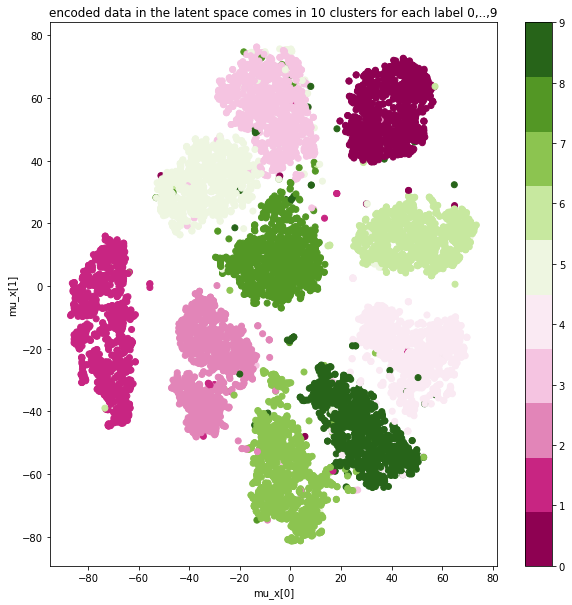

In [8]:
#  Visualization of the features of latent space x Given test_data
import matplotlib.pyplot as plt 
from pylab import *
cmap = cm.get_cmap('PiYG', 10) 
figure = plt.figure(figsize=(10,10))
plt.scatter(latent_embeded[:,0], latent_embeded[:,1], c=cat[:], cmap=cmap)
plt.colorbar()
plt.xlabel("mu_x[0]")
plt.ylabel("mu_x[1]")
plt.title("encoded data in the latent space comes in 10 clusters for each label 0,..,9")
plt.show()

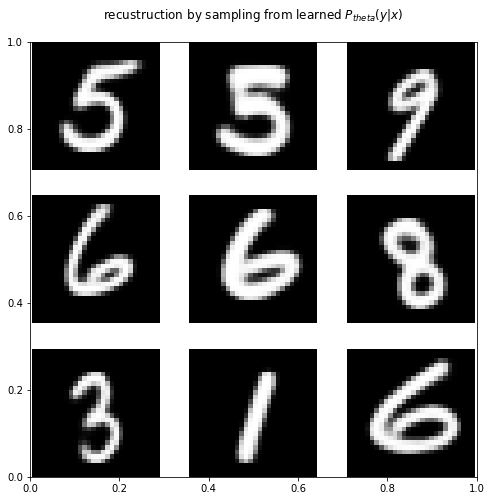

In [9]:
# image reconstruction 
x_hat = gmvae.decoder(Z[0])
x_hat = x_hat.detach().numpy()

figure = plt.figure(figsize=(8,8))
plt.title("recustruction by sampling from learned $P_{theta}(y|x)$\n")
row, col = 3, 3 
for i in range(1, row * col +1):
    sample_index = np.random.randint(len(x_hat), size=(1,))
    img = x_hat[sample_index].reshape(28,28)
    # img = img[
    figure.add_subplot(row, col, i)
    # plt.title(cat[sample_index])
    
    plt.imshow(img, cmap="gray")
    plt.axis("off")

In [10]:
# Random Generation of Data 
w_sample = torch.normal(mean=0, std=1, size=(16,150))
# w_sample = w_sample.to("cpu").detach().numpy()
mu_px, _ = gmvae.priorGenerator(w_sample)



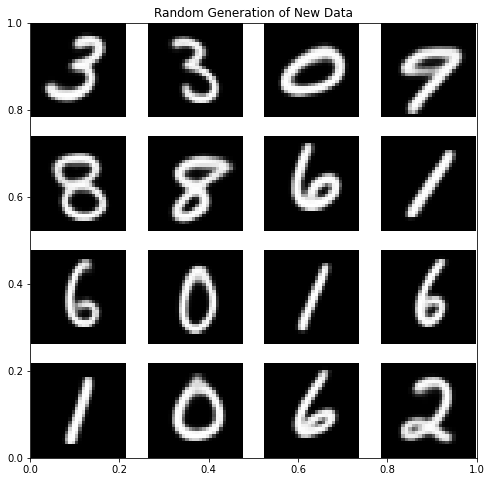

In [11]:
figure = plt.figure(figsize=(8,8))
plt.title("Random Generation of New Data")
row, col = 4, 4 
for i in range(1, row * col +1):
    sample_index = np.random.randint(10)
    latent_input = mu_px[:,:,sample_index].to("cpu")
    img = gmvae.decoder(latent_input)
    img = img.view(16,28,28)
    img = img[i-1,:,:].detach().numpy()
    # img = img[2]
    figure.add_subplot(row, col, i)
    plt.axis("off")
    plt.imshow(img, cmap="gray")